Using cache found in C:\Users\ronen/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\ronen/.cache\torch\hub\intel-isl_MiDaS_master


[INFO] Total frames: 1501, picking frame #1056
[INFO] Processing frame 1056

0: 384x640 2 persons, 4 cars, 1 motorcycle, 1 truck, 428.7ms
Speed: 32.6ms preprocess, 428.7ms inference, 30.0ms postprocess per image at shape (1, 3, 384, 640)


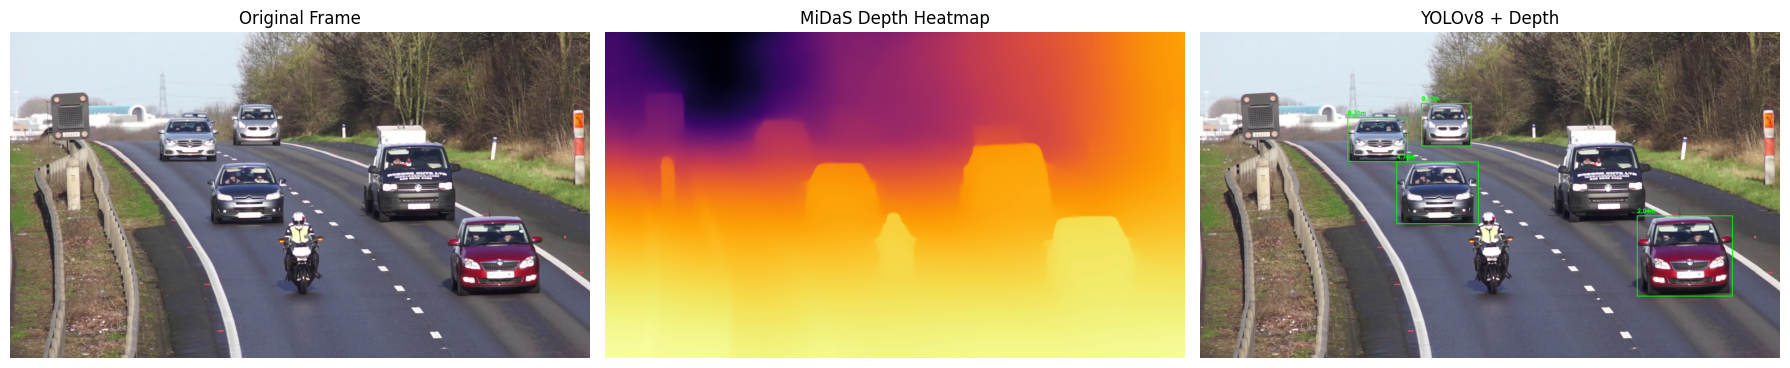

In [101]:
import cv2
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Load MiDaS model and transform
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Load YOLOv8
yolo = YOLO("yolov8s.pt")

def midas_depth(frame, scratcher = 3_000):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_np = np.array(img_rgb)

    result = transform(img_np)
    input_tensor = result["image"].to(device) if isinstance(result, dict) else result.to(device)

    if input_tensor.dim() == 3:
        input_tensor = input_tensor.unsqueeze(0)

    with torch.no_grad():
        prediction = midas(input_tensor)
        if prediction.dim() == 3:
            prediction = prediction.unsqueeze(1)
        elif prediction.dim() == 2:
            prediction = prediction.unsqueeze(0).unsqueeze(0)

        prediction_resized = torch.nn.functional.interpolate(
            prediction,
            size=img_np.shape[:2],
            mode="bicubic",
            align_corners=False
        )

    depth_map = prediction_resized.squeeze().cpu().numpy()

    # 🔄 Invert the MiDaS depth values properly: closer = larger number
    inverted_depth = scratcher * (1 / (depth_map + 1e-6))  # prevent divide by zero
    return inverted_depth




def depth_to_heatmap(depth_map):
    d_min, d_max = np.min(depth_map), np.max(depth_map)
    norm_depth = (depth_map - d_min) / (d_max - d_min + 1e-8)
    heatmap = (255 * (1 - norm_depth)).astype(np.uint8)
    return cv2.applyColorMap(heatmap, cv2.COLORMAP_INFERNO)

def annotate_with_yolo(frame, yolo_results, depth_map, gamma = 2):
    annotated = frame.copy()
    for result in yolo_results:
        for box in result.boxes:
            cls = int(box.cls[0])
            if cls != 2:  # Only keep 'car' class (class 2 in COCO)
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            cx = np.clip(cx, 0, depth_map.shape[1] - 1)
            cy = np.clip(cy, 0, depth_map.shape[0] - 1)
            distance = depth_map[cy, cx]

            distance *= gamma
            distance *= sigmoid(distance)

            # Only show distance (no 'car' label)
            label = f"{distance:.2f}m"
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return annotated


def plot_results(frame, depth_heatmap, yolo_annotated):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Frame")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(depth_heatmap, cv2.COLOR_BGR2RGB))
    axs[1].set_title("MiDaS Depth Heatmap")
    axs[1].axis("off")

    axs[2].imshow(cv2.cvtColor(yolo_annotated, cv2.COLOR_BGR2RGB))
    axs[2].set_title("YOLOv8 + Depth")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

def main(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    selected_frame_idx = random.randint(0, frame_count - 1)
    print(f"[INFO] Total frames: {frame_count}, picking frame #{selected_frame_idx}")

    current_frame = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if current_frame == selected_frame_idx:
            print(f"[INFO] Processing frame {current_frame}")
            depth_map = midas_depth(frame)
            depth_heatmap = depth_to_heatmap(depth_map)
            yolo_results = yolo(frame)
            annotated_frame = annotate_with_yolo(frame, yolo_results, depth_map)
            plot_results(frame, depth_heatmap, annotated_frame)
            break
        current_frame += 1

    cap.release()

# Run
video_path = "854671-hd_1920_1080_25fps.mp4"
main(video_path)
